In [39]:
from datetime import datetime
import itertools
import json
import math
import os
import sys

import geopandas
import importlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import psycopg2
import scipy
from scipy.spatial import KDTree
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils, database_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)
importlib.reload(database_utils)

from dotenv import load_dotenv
load_dotenv()

%matplotlib inline

RUN_FOLDER = "../results/throwaway/"

In [40]:
# Load run data
train_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "train_traces.pkl")
test_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "test_traces.pkl")
with open(RUN_FOLDER + "kcm/deeptte_formatted/" + "config.json") as f:
    config = json.load(f)
gtfs_data = data_utils.merge_gtfs_files("." + config['gtfs_folder'])
tte_train_chunks, tte_test = data_utils.load_train_test_data(RUN_FOLDER + "kcm/deeptte_formatted/", 5)

In [41]:
resolution = 128
timestep = 60
point_obs = train_traces[['speed_m_s','bearing','lon','lat','timeID_s']].values
grid_features = shape_utils.create_grid_features(point_obs[:,0], point_obs[:,1], point_obs[:,2], point_obs[:,3], point_obs[:,4], timestep, resolution)
print(grid_features.shape) # (xsteps, ysteps, tsteps, channels)
print(sys.getsizeof(grid_features)*1e-9)

(128, 128, 1440, 4)
0.18874384000000002


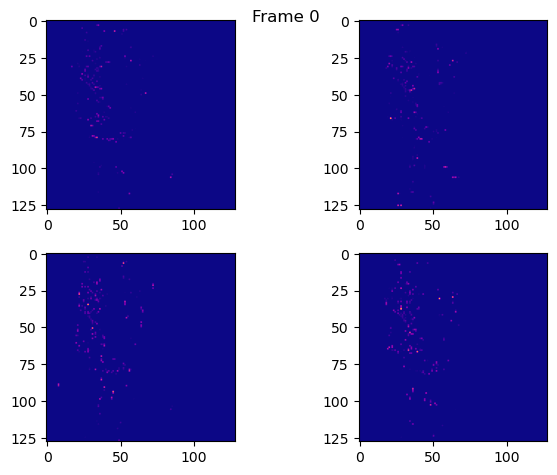

In [42]:
# Plot all channels
data = grid_features[:,:,600:1200,:]
fig, axes = plt.subplots(2,2)
axes = axes.reshape(-1)
fig.tight_layout()

# Define the update function that will be called for each frame of the animation
def update(frame):
    fig.suptitle(f"Frame {frame}")
    for i, ax in enumerate(axes):
        ax.clear()
        ax.imshow(data[:,:,frame,i], cmap='plasma', vmin=0.0, vmax=35.0)

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=data.shape[2])

# Save the animation object
ani.save(f"../plots/grid_speeds.mp4", fps=10, dpi=300)

In [ ]:
# Work with a single trip
shingle_data = test_traces[test_traces['shingle_id']==5885]
shingle_data.head()

In [ ]:
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], gtfs_data)
shape_utils.plot_gtfsrt_trip(axes, plot_data)

In [ ]:
# Plot closest stop updates across shingle
plot_data = shingle_data
next_stops = plot_data[['stop_lon','stop_lat','timeID_s']]
next_stops.columns = ["lon","lat","timeID_s"]
next_stops['Type'] = "Nearest Scheduled Stop"
next_points = shingle_data[['lon','lat','timeID_s']]
next_points['Type'] = "Current Position"
next_points = shape_utils.interpolate_trajectories(next_points, 'Type')
next_stops = shape_utils.fill_trajectories(next_stops, np.min(next_points['timeID_s']), np.max(next_points['timeID_s']), 'Type')
plot_data = pd.concat([next_points, next_stops], axis=0)

fig = px.scatter(
    plot_data,
    title=f"Nearest Stop to Target",
    x="lon",
    y="lat",
    range_x=[np.min(plot_data['lon'])-.01, np.max(plot_data['lon'])+.01],
    range_y=[np.min(plot_data['lat'])-.01, np.max(plot_data['lat'])+.01],
    animation_frame="timeID_s",
    animation_group="Type",
    color="Type"
)
fig.update_traces(marker={'size': 15})
fig.update_layout(
  template='plotly_dark',
  margin=dict(r=60, t=25, b=40, l=60)
)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.write_html("../plots/nearest_stop.html")
fig.show()

In [ ]:
shingle_id = 5885
dist = .002
t_buffer = 60
shingle_data, adjacent_data = shape_utils.get_adjacent_points(test_traces, shingle_id, t_buffer, dist)

# Join and interpolate each trajectory
plot_shingle_data = shape_utils.interpolate_trajectories(shingle_data, 'shingle_id')
plot_shingle_data['Type'] = 'Trajectory'
plot_adjacent_data = shape_utils.interpolate_trajectories(adjacent_data, 'shingle_id')
plot_adjacent_data['Type'] = 'Adjacent Trip'
# For some reason Plotly needs data to be sorted by the animation frame
plot_data = pd.concat([plot_shingle_data, plot_adjacent_data], axis=0).sort_values(['timeID_s','shingle_id'])

# Plot adjacent shingles
fig = px.scatter(
    plot_data,
    title=f"Active Shingles Within {dist*111*1000}m and {t_buffer}s of Target",
    x="lon",
    y="lat",
    range_x=[np.min(plot_data['lon'])-.01, np.max(plot_data['lon'])+.01],
    range_y=[np.min(plot_data['lat'])-.01, np.max(plot_data['lat'])+.01],
    animation_frame="timeID_s",
    animation_group="shingle_id",
    # color="Type", # For some reason this breaks the animation order
    text="Type"
)
fig.update_layout(
  template='plotly_dark',
  margin=dict(r=60, t=25, b=40, l=60)
)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 30
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 5
fig.write_html("../plots/adjacent_trips.html")
fig.show()

In [ ]:
# Show overview of trace and adjacent on a map
px.set_mapbox_access_token(os.getenv('MAPBOX_TOKEN'))
fig = px.scatter_mapbox(
    plot_data,
    lon="lon",
    lat="lat",
    color="Type"
)
fig.update_layout(
  margin=dict(r=60, t=25, b=40, l=60)
)
fig.write_html("../plots/adjacent_trip_traces.html")
fig.show()

In [ ]:
# Trying to find relationships between nearby trips and ongoing trip
dist = .002
t_buffer = 60 * 1
shingle_ids = pd.unique(test_traces['shingle_id'])[:1000]
adj_metric = np.empty(len(shingle_ids))
target_metric = np.empty(len(shingle_ids))

# Get values for adjacent points to a subset of shingles
for i, shingle_id in enumerate(shingle_ids):
    shingle_data, adjacent_data = shape_utils.get_adjacent_points(test_traces, shingle_id, t_buffer, dist)
    # Test different metrics for evaluating adjacent traces on target trace
    target_metric[i] = np.mean(shingle_data.speed_m_s)
    adj_metric[i] = np.mean(adjacent_data.speed_m_s)

# Fill points with no adjacent with global average
adj_metric = np.nan_to_num(adj_metric, nan=np.mean(adj_metric[~np.isnan(adj_metric)]))

In [ ]:
x = adj_metric
y = target_metric

# Fit polynomial to the data
z = np.polyfit(x=x, y=y, deg=2)
x_val = np.arange(np.min(x),np.max(x),.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((y - p(x))**2)
SST = np.sum((y - np.mean(y))**2)
R2 = 1 - (SSR/SST)
print(f"R2: {R2}")

plot_data = pd.concat([
    pd.DataFrame({
        "x": x,
        "y": y,
        "Type": "data"
    }),
    pd.DataFrame({
        "x": x_val,
        "y": y_val,
        "Type": "pred"
    })
])
fig = px.scatter(
    plot_data,
    y="y",
    color="Type",
    x="x",
    title=f"Mean Adjacent Speed D=2 Polynomial R-Squared: {np.round(R2,3)}",
    labels={
        "x": "Mean Speed of Adjacent Trips (m/s)",
        "y": "Mean Speed of Target Trip (m/s)",
    }
)
fig.write_image("../plots/speed_reg.png")
fig.show()

In [ ]:
zero_idx_adj = adj_metric!=0.0
zero_idx_target = target_metric!=0.0
x = np.log(adj_metric[zero_idx_adj & zero_idx_target])
y = np.log(target_metric[zero_idx_adj & zero_idx_target])

# Fit polynomial to the data
z = np.polyfit(x=x, y=y, deg=2)
x_val = np.arange(np.min(x),np.max(x),.1)
p = np.poly1d(z)
y_val = p(x_val)

# Get metrics
# R2: variance explained by model / total variance
SSR = np.sum((y - p(x))**2)
SST = np.sum((y - np.mean(y))**2)
R2 = 1 - (SSR/SST)
print(f"R2: {R2}")

plot_data = pd.concat([
    pd.DataFrame({
        "x": x,
        "y": y,
        "Type": "data"
    }),
    pd.DataFrame({
        "x": x_val,
        "y": y_val,
        "Type": "pred"
    })
])
fig = px.scatter(
    plot_data,
    y="y",
    color="Type",
    x="x",
    title=f"Log Mean Adjacent Speed D=2 Polynomial R-Squared: {np.round(R2,3)}",
    labels={
        "x": "Mean Speed of Adjacent Trips Log(m/s)",
        "y": "Mean Speed of Target Trip Log(m/s)",
    }
)
fig.write_image("../plots/log_speed_reg.png")
fig.show()